In [1]:
# data handling
import numpy as np
import pandas as pd

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# feature selection
from sklearn.feature_selection import RFE

# machine learning algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# dimensionality reduction with PCA
from sklearn.decomposition import PCA

# accuracy metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-4/Data-dictionary.xlsx
/kaggle/input/data-storm-4/DataStorm4.0_KaggleProblemStatement.pdf
/kaggle/input/data-storm-4/Store-info.csv
/kaggle/input/data-storm-4/Testing-data.csv
/kaggle/input/data-storm-4/Historical-transaction-data.csv


In [3]:
store_db = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
transaction_db = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')
test_db = pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv')

## Creating the Master Table of Data based on Transactions and the corresponding Store 

In [4]:
table = pd.merge(transaction_db, store_db)

### Splitting data into smaller ones on the Master Data

In [5]:
# Amount of money spent in rupees for each transaction by each person on a particular item
table['amount'] = table['item_price'] * table['quantity_sold']

# Handling the date
table['transaction_date'] = table['transaction_date'].str.split("T",n=1,expand=True)[0]
table['transaction_date'] = pd.to_datetime(table['transaction_date'],format="%Y-%m-%d")

# Splitting the date components
table['year'] = table['transaction_date'].dt.year
table['month'] = table['transaction_date'].dt.month
table['date'] = table['transaction_date'].dt.day
table['weekday'] = table['transaction_date'].dt.weekday 

In [6]:
price_item_modes = table.groupby(['item_price'])['item_description'].agg(pd.Series.mode)

for i in price_item_modes.index:
    if type(price_item_modes[i]) == np.ndarray:
        price_item_modes[i] = np.NaN
        
table['item_description'] = table['item_description'].fillna(table['item_price'].map(price_item_modes))

In [7]:
table.dropna(subset=['item_description'], inplace=True)

In [8]:
# Obtaining the beverage type and the volume of the beverage in each transaction
item_desc_split = table['item_description'].str.rsplit(" ",n=1,expand=True)
table['beverage_description'] = item_desc_split[0]
table['volume_type'] = item_desc_split[1]

# Obtaining the volume of the beverage bottles as millilitres
# code obtained from https://stackoverflow.com/a/61041274 
vol_data = table.volume_type.str.extract(r'(?i)\b(\d+(?:\.\d+)?)\s*(ML|L)\b', expand=True)
vol_data[0] = vol_data[0].astype(float)

vol_data = vol_data.replace(['ML','L'],[0,1])
vol_data[1].astype(float)

vol_data[0] = vol_data[0] + vol_data[1]*999*vol_data[0]

table['volume_ml'] = vol_data[0]

In [9]:
reordered_cols = ['month','date','weekday','invoice_id','customer_id','beverage_description',
                  'volume_ml','item_price','quantity_sold','amount','shop_id','shop_area_sq_ft',
                  'shop_profile']
table = table[reordered_cols]
table

,month,date,weekday,invoice_id,customer_id,beverage_description,volume_ml,item_price,quantity_sold,amount,shop_id,shop_area_sq_ft,shop_profile
0,12,11,5,147.0,BGXA,ORANGE BARLEY,1500.0,220,2,440,SHOP008,678,Moderate
1,12,13,0,484.0,VN7V,TONIC PET,500.0,160,2,320,SHOP008,678,Moderate
2,12,13,0,484.0,VN7V,CREAM SODA,1000.0,150,2,300,SHOP008,678,Moderate
3,12,10,4,1000053.0,VT9C,GINGER BEER,1500.0,220,1,220,SHOP008,678,Moderate
4,12,10,4,1000057.0,8QLS,GINGER BEER,1500.0,440,1,440,SHOP008,678,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
473969,12,9,3,7030409.0,QVA7,SODA,500.0,70,1,70,SHOP072,617,High
473970,12,11,5,7030809.0,HXMG,FIT O ORANGE,200.0,140,2,280,SHOP072,617,High
473971,12,11,5,7030820.0,OUH2,BOTTLED DRINKING WATER,500.0,35,1,35,SHOP072,617,High
473972,10,21,3,NaN,5IJM,GINGER BEER,1500.0,220,1,220,SHOP072,617,High


## Handling Missing Values

There are two features in the original dataset that have missing values. 
1. Invoice Number
2. Item Description (now split as beverage_description & volume_ml)

To impute the missing invoice numbers we will assume that all transactions that were done using the same customer_id on the same date to be considered as a single invoice. Since we only to identify whether these transactions belong to the same invoice, it is not necessary to identify the correct the invoice id number. Instead we will create a new invoice number starting from the last invoice recorded in the table (i.e. highest number in the invoice_id column)

In [10]:
no_inv_db = table.loc[table.invoice_id.isna()]
invoice_index = no_inv_db.sort_values(['customer_id','month','date']).groupby(
    ['customer_id','month','date']).count().index

invoice_i = table.invoice_id.max() + 1
for idx in invoice_index:
    no_inv_db.loc[(no_inv_db.customer_id == idx[0]) &
                  (no_inv_db.month == idx[1]) & 
                  (no_inv_db.date == idx[2]),'invoice_id'] = invoice_i
    invoice_i += 1
    
table.loc[table.invoice_id.isna()] = no_inv_db

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


It is idenitified that shop with id 'SHOP008' has only being functioning in the month December and hence will be dropped from the training data

table = table.loc[table.shop_id != 'SHOP008']
store_db = store_db.loc[store_db.shop_id != 'SHOP008']

In [11]:
table.loc[table.shop_id == 'SHOP047']

,month,date,weekday,invoice_id,customer_id,beverage_description,volume_ml,item_price,quantity_sold,amount,shop_id,shop_area_sq_ft,shop_profile
21177,10,17,6,30956.0,4OFQ,SODA,1000.0,110,1,110,SHOP047,528,Moderate
21178,10,20,2,31418.0,KQYP,ORANGE BARLEY,1500.0,220,1,220,SHOP047,528,Moderate
21179,11,1,0,33467.0,WCZT,GINGER BEER,1500.0,220,2,440,SHOP047,528,Moderate
21180,11,6,5,34265.0,KD8T,FIT O MIXED FRUIT,200.0,60,1,60,SHOP047,528,Moderate
21181,11,6,5,34265.0,KD8T,GINGER BEER,1500.0,220,2,440,SHOP047,528,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,11,18,3,2026696.0,ULVU,NECTO,500.0,100,1,100,SHOP047,528,Moderate
22865,11,28,6,2027937.0,5C5L,SODA,1000.0,110,2,220,SHOP047,528,Moderate
22866,10,23,5,3011507.0,IN28,LEMONADE,1500.0,220,2,440,SHOP047,528,Moderate
22867,10,23,5,3011514.0,4QJ5,GINGER BEER,400.0,600,7,4200,SHOP047,528,Moderate


## Forming Aggregate Data Regarding each shop

In [12]:
store_table = store_db.copy()

store_table = store_table.loc[store_table.shop_id != "SHOP008"]
store_table

In [13]:
def add_new_feature(database, col_name, new_series):
    database[col_name] = 0
    i=0
    for idx in database.shop_id:
        database.loc[i, col_name] = new_series.loc[idx][0]
        i+=1
    return database

In [14]:
all_shop_index = store_table.shop_id
all_shop_index = all_shop_index.dropna()
all_shop_index

0      SHOP047
1      SHOP009
2      SHOP083
3      SHOP117
4      SHOP042
        ...   
119    SHOP087
120    SHOP050
121    SHOP061
122    SHOP056
123    SHOP070
Name: shop_id, Length: 124, dtype: object

In [15]:
tot_sales = pd.DataFrame( table.groupby('shop_id', sort=False)['amount'].sum())
store_table = add_new_feature(store_table, 'tot_sales', tot_sales)

In [16]:
oct_sales = pd.DataFrame(table.loc[table.month == 10].groupby('shop_id',sort=False)['amount'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'oct_sales', oct_sales)

In [17]:
nov_1_sales = pd.DataFrame(table.loc[(table.month == 11) & (table.date <= 15)].groupby('shop_id',sort=False)['amount'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'nov_1_sales', nov_1_sales)

In [18]:
nov_2_sales = pd.DataFrame(table.loc[(table.month == 11) & (table.date > 15)].groupby('shop_id',sort=False)['amount'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'nov_2_sales', nov_2_sales)

In [19]:
dec_sales = pd.DataFrame(table.loc[table.month == 12].groupby('shop_id',sort=False)['amount'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'dec_sales', dec_sales)

In [20]:
tot_customers = pd.DataFrame( table.groupby('shop_id',sort=False)['customer_id'].nunique(), index=all_shop_index).astype(int)
store_table = add_new_feature(store_table, 'tot_customers', tot_customers)

In [21]:
oct_customers = pd.DataFrame(table.loc[table.month == 10].groupby('shop_id',sort=False)['customer_id'].nunique(),index=all_shop_index)
store_table = add_new_feature(store_table, 'oct_customers', oct_customers)

In [22]:
nov_1_customers = pd.DataFrame(table.loc[(table.month == 11) & (table.date <= 15)].groupby('shop_id',sort=False)['customer_id'].nunique(),index=all_shop_index)
store_table = add_new_feature(store_table, 'nov_1_customers', nov_1_customers)

In [23]:
nov_2_customers = pd.DataFrame(table.loc[(table.month == 11) & (table.date > 15)].groupby('shop_id',sort=False)['customer_id'].nunique(),index=all_shop_index)
store_table = add_new_feature(store_table, 'nov_2_customers', nov_2_customers)

In [24]:
dec_customers = pd.DataFrame(table.loc[table.month == 12].groupby('shop_id',sort=False)['customer_id'].nunique(),index=all_shop_index)
store_table = add_new_feature(store_table, 'dec_customers', dec_customers)

In [25]:
visit_per_customer = pd.DataFrame(table.groupby('shop_id')['customer_id'].value_counts())
onetime_customers = visit_per_customer.loc[visit_per_customer.customer_id == 1].groupby('shop_id').count()
store_table = add_new_feature(store_table, 'onetime_customers', onetime_customers)

In [26]:
frequent_customers = visit_per_customer.loc[visit_per_customer.customer_id > 16].groupby('shop_id').count()
frequent_customers = pd.DataFrame(frequent_customers, index=all_shop_index)
frequent_customers = frequent_customers.fillna(0)
store_table = add_new_feature(store_table, 'frequent_customers', frequent_customers)

In [27]:
small_bottle_quantity = pd.DataFrame(table.loc[table.volume_ml <= 200].groupby('shop_id',sort=False)['quantity_sold'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'small_bottle_quantity', small_bottle_quantity)

In [28]:
medium_bottle_quantity = pd.DataFrame(table.loc[(table.volume_ml > 200) & (table.volume_ml <= 500)].groupby('shop_id',sort=False)['quantity_sold'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'medium_bottle_quantity', medium_bottle_quantity)
# medium_bottle_quantity

In [29]:
large_bottle_quantity = pd.DataFrame(table.loc[table.volume_ml >= 1000].groupby('shop_id',sort=False)['quantity_sold'].sum(),index=all_shop_index)
store_table = add_new_feature(store_table, 'large_bottle_quantity', large_bottle_quantity)

In [30]:
items_per_bill = table.groupby(['shop_id','invoice_id','customer_id'])['quantity_sold'].sum()
max_items_bill = items_per_bill.groupby(['shop_id']).max()
store_table['max_items_bill'] = 0
i=0
for idx in store_table.shop_id:
    store_table.loc[i, 'max_items_bill'] = max_items_bill.loc[idx]
    i+=1

In [31]:
bulk_item_customers = pd.DataFrame(items_per_bill.loc[items_per_bill > 30].groupby('shop_id').count(), index=all_shop_index)
bulk_item_customers = bulk_item_customers.fillna(0)
store_table = add_new_feature(store_table, 'bulk_item_customers', bulk_item_customers)

In [32]:
table.beverage_description.unique()

array(['ORANGE BARLEY', 'TONIC PET', 'CREAM SODA', 'GINGER BEER',
       'CREAM SODA APPLE POP', 'SODA', 'BOTTLED DRINKING WATER',
       'LEMONADE', 'KIK COLA', 'STRAWBERRY MILK', 'SODA PET',
       'FIT O MIXED FRUIT', 'NECTO', 'FIT O ORANGE', 'FIT O MANGO',
       'GINGER BEER SUGAR FREE', 'ORANGE CRUSH', 'CHOCOLATE MILK',
       'TWISTEE APPLE', 'DRY GINGER ALE PET', 'LIME CRUSH JUICE'],
      dtype=object)

In [33]:
soft_drinks = ['ORANGE BARLEY','TONIC PET','CREAM SODA','GINGER BEER','CREAM SODA APPLE POP','SODA',
               'LEMONADE','KIK COLA','SODA PET','NECTO','GINGER BEER SUGAR FREE','ORANGE CRUSH',
               'DRY GINGER ALE PET','LIME CRUSH JUICE']
water = ['BOTTLED DRINKING WATER']
fruit_drinks = ['FIT O MIXED FRUIT','FIT O ORANGE','FIT O MANGO','TWISTEE APPLE']
milk_drinks = ['CHOCOLATE MILK','STRAWBERRY MILK']

In [34]:
# top_5_drinks = table.groupby('beverage_description')['quantity_sold'].sum().nlargest(5).index

# for drink in top_5_drinks:
#     drink_db = table.loc[table.beverage_description == drink]
#     drink_db = pd.DataFrame(table.loc[drink_db.index].groupby(['shop_id'],sort=False)['amount'].sum(), index=all_shop_index)
#     drink_db = drink_db.amount.fillna(0)
    
#     drink_db = pd.Series(drink_db)
# #     store_table = add_new_feature(store_table, drink, drink_db)
#     store_table[drink] = 0
#     i=0
#     for idx in store_table.shop_id:
#         store_table.loc[i, drink] = drink_db.loc[idx]
#         i+=1

In [35]:
for drink in soft_drinks:
    drink_db = table.loc[table.beverage_description == drink]
    drink_db = pd.DataFrame(table.loc[drink_db.index].groupby(['shop_id'],sort=False)['amount'].sum(), index=all_shop_index)
    drink_db = drink_db.amount.fillna(0)
    
    drink_db = pd.Series(drink_db)
#     store_table = add_new_feature(store_table, drink, drink_db)
    store_table[drink] = 0
    i=0
    for idx in store_table.shop_id:
        store_table.loc[i, drink] = drink_db.loc[idx]
        i+=1

In [36]:
milk_sale_data = pd.Series(table['beverage_description'].isin(milk_drinks))
milk_sales = pd.DataFrame(table.loc[milk_sale_data].groupby('shop_id',sort=False)['amount'].sum(), index=all_shop_index)
store_table = add_new_feature(store_table, 'milk_sales', milk_sales)

In [37]:
soft_d_sale_data = pd.Series(table['beverage_description'].isin(soft_drinks))
soft_d_sales = pd.DataFrame(table.loc[soft_d_sale_data].groupby('shop_id',sort=False)['amount'].sum(), index=all_shop_index)
store_table = add_new_feature(store_table, 'soft_d_sales', soft_d_sales)

In [38]:
water_sale_data = pd.Series(table['beverage_description'].isin(water))
water_sales = pd.DataFrame(table.loc[water_sale_data].groupby('shop_id',sort=False)['amount'].sum(), index=all_shop_index)
store_table = add_new_feature(store_table, 'water_sales', water_sales)

In [39]:
fruit_d_sale_data = pd.Series(table['beverage_description'].isin(fruit_drinks))
fruit_d_sales = pd.DataFrame(table.loc[fruit_d_sale_data].groupby('shop_id',sort=False)['amount'].sum(), index=all_shop_index)
store_table = add_new_feature(store_table, 'fruit_d_sales', fruit_d_sales)

In [40]:
invoice_data = pd.DataFrame(table.groupby(['shop_id','invoice_id'])['amount'].sum(),)
avg_bill_value = pd.DataFrame(invoice_data.groupby('shop_id')['amount'].mean().round(2))
store_table = add_new_feature(store_table, 'avg_bill_value', avg_bill_value)

In [41]:
weekday_avg_sales = table.groupby(['weekday','shop_id'])['amount'].sum()
saturday_avg_sales = pd.DataFrame(weekday_avg_sales[5])
sunday_avg_sales = pd.DataFrame(weekday_avg_sales[6])
weekend_avg_sales = pd.DataFrame(round((saturday_avg_sales['amount'] + sunday_avg_sales['amount'])/18,2))
store_table = add_new_feature(store_table, 'weekend_avg_sales', weekend_avg_sales)

In [42]:
customer_per_day = pd.DataFrame(table.groupby(['shop_id','month','date'])['customer_id'].nunique())
customer_per_day = pd.DataFrame(customer_per_day.groupby('shop_id')['customer_id'].mean().round(0)).astype(int)
store_table = add_new_feature(store_table, 'customer_per_day', customer_per_day)

In [43]:
tot_orders = pd.DataFrame(table.groupby(['shop_id','month','date'])['invoice_id'].nunique())
tot_orders = pd.DataFrame(tot_orders.groupby('shop_id')['invoice_id'].sum().round(0)).astype(int)
store_table = add_new_feature(store_table,'tot_orders',tot_orders)

In [44]:
tot_items = pd.DataFrame(table.groupby(['shop_id','month','date'])['quantity_sold'].sum())
tot_items = pd.DataFrame(tot_items.groupby('shop_id')['quantity_sold'].sum().round(0)).astype(int)
store_table = add_new_feature(store_table,'tot_items',tot_items)

In [45]:
store_table.tail(24)

,shop_id,shop_area_sq_ft,shop_profile,tot_sales,oct_sales,nov_1_sales,nov_2_sales,dec_sales,tot_customers,oct_customers,...,LIME CRUSH JUICE,milk_sales,soft_d_sales,water_sales,fruit_d_sales,avg_bill_value,weekend_avg_sales,customer_per_day,tot_orders,tot_items
100,SHOP046,545,NaN,2607865,556485.0,291355.0,879035.0,880990,1736,679.0,...,0,34640,1743320,578515,251390,944.54,32302.22,44,2761,6941
101,SHOP024,676,NaN,1308795,335055.0,275830.0,325445.0,372465,1641,575.0,...,0,22880,1075760,63525,146630,565.35,22019.72,37,2315,5274
102,SHOP023,617,NaN,2553330,916485.0,445670.0,544750.0,646425,2227,799.0,...,0,65750,1759360,185710,542510,802.68,50219.17,51,3181,7923
103,SHOP097,310,NaN,2375735,610460.0,580165.0,477535.0,707575,1667,600.0,...,0,221930,1660760,160895,332150,962.23,38967.78,40,2469,6793
104,SHOP044,715,NaN,1251090,348525.0,184870.0,299685.0,418010,1550,546.0,...,0,37190,1087740,9870,116290,598.89,28303.06,34,2089,4916
105,SHOP030,530,NaN,2754185,1003750.0,343845.0,539280.0,867310,1636,696.0,...,14300,75365,1963090,347690,368040,989.65,41864.72,44,2783,7623
106,SHOP038,411,NaN,1444025,407920.0,207175.0,295035.0,533895,1781,681.0,...,0,27950,1104080,98035,213960,553.48,30876.94,42,2609,5728
107,SHOP029,597,NaN,1962105,489030.0,323595.0,534205.0,615275,2052,601.0,...,0,55100,1363780,203245,339980,674.96,46140.28,47,2907,7332
108,SHOP096,676,NaN,2600915,681745.0,372665.0,653965.0,892540,2497,911.0,...,0,29175,2190780,105350,275610,692.84,48126.39,60,3754,9049
109,SHOP092,617,NaN,1961240,504345.0,334230.0,634050.0,488615,2247,786.0,...,0,51300,1375610,51870,482460,661.24,35130.83,48,2966,7266


## Futher Feature Combining

To simplify and combine some of the features

Using Sales Growth to emphasize instead of separate monthly sale figures

In [46]:
store_table['oct_sales_ratio'] = (store_table['oct_sales'] / store_table['tot_sales'])
store_table['nov1_sales_ratio'] = (store_table['nov_1_sales'] / store_table['tot_sales'])
store_table['nov2_sales_ratio'] = (store_table['nov_2_sales'] / store_table['tot_sales'])
store_table['dec_sales_ratio'] = (store_table['dec_sales'] / store_table['tot_sales'])

store_table = store_table.drop(columns=['oct_sales','nov_1_sales','nov_2_sales','dec_sales'])

In [47]:
tot_items = pd.DataFrame( table.groupby('shop_id', sort=False)['quantity_sold'].sum())
store_table = add_new_feature(store_table, 'tot_items', tot_items)

In [48]:
soft_d_sale_data = pd.Series(table['beverage_description'].isin(soft_drinks))
soft_d_quantity = pd.DataFrame(table.loc[soft_d_sale_data].groupby('shop_id',sort=False)['quantity_sold'].sum(), index=all_shop_index)
store_table = add_new_feature(store_table, 'soft_d_quantity', soft_d_quantity)
store_table['soft_d_quantity'] = store_table['soft_d_quantity'] / store_table['tot_items']

In [49]:
store_table['oct_cust_ratio'] = (store_table['oct_customers'] / store_table['tot_customers'])
store_table['nov1_cust_ratio'] = (store_table['nov_1_customers'] / store_table['tot_customers'])
store_table['nov2_cust_ratio'] = (store_table['nov_2_customers'] / store_table['tot_customers'])
store_table['dec_cust_ratio'] = (store_table['dec_customers'] / store_table['tot_customers'])

store_table = store_table.drop(columns=['oct_customers','nov_1_customers','nov_2_customers','dec_customers'])

In [50]:
store_table['small_bottle_ratio'] = store_table['small_bottle_quantity'] / store_table['tot_items']
store_table['medium_bottle_ratio'] = store_table['medium_bottle_quantity'] / store_table['tot_items']
store_table['large_bottle_ratio'] = store_table['large_bottle_quantity'] / store_table['tot_items']

store_table = store_table.drop(columns=['small_bottle_quantity','medium_bottle_quantity','large_bottle_quantity'])

In [51]:
store_table['footprint_perarea'] = store_table['customer_per_day'] / store_table['shop_area_sq_ft']

In [52]:
store_table['orders_per_customer'] = (store_table['tot_orders'] / store_table['tot_customers'])

In [53]:
store_table.columns

Index(['shop_id', 'shop_area_sq_ft', 'shop_profile', 'tot_sales',
       'tot_customers', 'onetime_customers', 'frequent_customers',
       'max_items_bill', 'bulk_item_customers', 'ORANGE BARLEY', 'TONIC PET',
       'CREAM SODA', 'GINGER BEER', 'CREAM SODA APPLE POP', 'SODA', 'LEMONADE',
       'KIK COLA', 'SODA PET', 'NECTO', 'GINGER BEER SUGAR FREE',
       'ORANGE CRUSH', 'DRY GINGER ALE PET', 'LIME CRUSH JUICE', 'milk_sales',
       'soft_d_sales', 'water_sales', 'fruit_d_sales', 'avg_bill_value',
       'weekend_avg_sales', 'customer_per_day', 'tot_orders', 'tot_items',
       'oct_sales_ratio', 'nov1_sales_ratio', 'nov2_sales_ratio',
       'dec_sales_ratio', 'soft_d_quantity', 'oct_cust_ratio',
       'nov1_cust_ratio', 'nov2_cust_ratio', 'dec_cust_ratio',
       'small_bottle_ratio', 'medium_bottle_ratio', 'large_bottle_ratio',
       'footprint_perarea', 'orders_per_customer'],
      dtype='object')

In [54]:
# since the shop008 was only functioning in the month of December - it is excluded from the training process
store_table = store_table.loc[store_table.shop_id != "SHOP008"]
store_table

,shop_id,shop_area_sq_ft,shop_profile,tot_sales,tot_customers,onetime_customers,frequent_customers,max_items_bill,bulk_item_customers,ORANGE BARLEY,...,soft_d_quantity,oct_cust_ratio,nov1_cust_ratio,nov2_cust_ratio,dec_cust_ratio,small_bottle_ratio,medium_bottle_ratio,large_bottle_ratio,footprint_perarea,orders_per_customer
0,SHOP047,528,Moderate,838280,928,610,3,47,1,36300,...,0.747484,0.398707,0.235991,0.275862,0.313578,0.138457,0.347362,0.514181,0.039773,1.408405
1,SHOP009,676,High,1966710,2498,1596,0,38,2,102520,...,0.787695,0.359488,0.220576,0.286629,0.388711,0.092348,0.371058,0.536594,0.084320,1.417134
2,SHOP083,676,Low,1691985,1900,1200,2,25,0,146080,...,0.793949,0.366842,0.242632,0.286842,0.363684,0.088049,0.302830,0.609121,0.065089,1.442105
3,SHOP117,676,Low,2325980,2037,1196,3,47,5,125180,...,0.818779,0.362788,0.265096,0.295042,0.396171,0.088071,0.299269,0.612659,0.075444,1.562592
4,SHOP042,676,Low,1340215,1841,1247,1,30,0,107580,...,0.795688,0.348180,0.222705,0.281912,0.380228,0.081964,0.350103,0.567933,0.059172,1.370994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,1083,678,2,21,0,53240,...,0.809333,0.357341,0.225300,0.282548,0.362881,0.093600,0.281600,0.624800,0.045541,1.403509
120,SHOP050,411,NaN,2399125,1778,956,2,41,2,181720,...,0.827595,0.410574,0.218785,0.322272,0.469629,0.087767,0.264997,0.647235,0.124088,1.788526
121,SHOP061,699,NaN,2106120,1745,1104,3,126,2,88000,...,0.761747,0.348997,0.198281,0.290544,0.377077,0.112674,0.220218,0.667108,0.054363,1.361605
122,SHOP056,597,NaN,3018540,2831,1706,7,69,2,184140,...,0.757665,0.357471,0.225362,0.305546,0.418933,0.122557,0.344181,0.533262,0.118928,1.554221


## PCA Analysis

Since we noticed that the Moderate profiled shops are not being predicted as well, we wish to locate if there are certain features which heavily influence a shop to fall under the Moderate Class

In [55]:
def get_prominent_features(train, category):
    
    df = train.loc[train.shop_profile == category].drop(columns=['shop_profile','shop_id'])
    
    print("****Selecting Prominent Features for " + str(category) + str("****\n"))
    
    pca = PCA()
    train_pca_cat = pca.fit_transform(df)
    component_names = [f"PC{i+1}" for i in range(train_pca_cat.shape[1])]
    train_pca_cat = pd.DataFrame(train_pca_cat, columns=component_names)

    loadings = pd.DataFrame(
        pca.components_.T,
        columns = component_names,
        index=df.columns)

    pro_fea = pd.DataFrame(columns=['PCA','High1','High2','Low2','Low1','h1_h2','l1_l2','h1_l1','large_fea']) 

    i=0
    for PCAcol in component_names:

        ord_load = loadings[PCAcol].sort_values()
        ord_load = pd.DataFrame(ord_load, columns=[PCAcol])
        
        low1_fea = ord_load.iloc[0].name
        low2_fea = ord_load.iloc[1].name
        high1_fea = ord_load.iloc[-1].name
        high2_fea = ord_load.iloc[-2].name

        low1_val = ord_load.iloc[0,0]
        low2_val = ord_load.iloc[1,0]
        high1_val = ord_load.iloc[-1,0]
        high2_val = ord_load.iloc[-2,0]

        h1_h2 = round(abs(high1_val * high2_val)**0.5,3)
        l1_l2 = round(abs(low1_val * low2_val)**0.5,3)
        h1_l1 = round(abs(low1_val * high1_val)**0.5,3)

        large_fea = 0
        if (low1_val <= -0.8):
            large_fea = low1_fea
        if (high1_val >= 0.8):
            large_fea = high1_fea

        arr = [PCAcol, high1_fea, high2_fea, low2_fea, low1_fea, h1_h2, l1_l2, h1_l1, large_fea]

        pro_fea.loc[i] = arr
        i+=1
    
    print("Prominent Single Features")
    pro_single = pro_fea.loc[pro_fea.large_fea != 0,['PCA','large_fea']]
    if pro_single.size !=0:
        print(pro_single)
        
    print("\n Prominent Pairs of Features which can be combined")   
    h1_h2_df = pro_fea.loc[pro_fea.h1_h2 > 0.6, ['PCA','High1','High2','h1_h2']]
    l1_l2_df = pro_fea.loc[pro_fea.l1_l2 > 0.6, ['PCA','Low1','Low2','l1_l2']]
    h1_l1_df = pro_fea.loc[pro_fea.h1_l1 > 0.6, ['PCA','High1','Low1','h1_l1']]
    
    if h1_h2_df.size != 0:
        print(h1_h2_df)
        print("")
    if l1_l2_df.size != 0:
        print(l1_l2_df)
        print("")
    if h1_l1_df.size != 0:
        print(h1_l1_df)
        print("")
    print("")

In [56]:
get_prominent_features(store_table, 'Moderate')

****Selecting Prominent Features for Moderate****

Prominent Single Features
     PCA           large_fea
0    PC1           tot_sales
15  PC16    LIME CRUSH JUICE
16  PC17   weekend_avg_sales
17  PC18            KIK COLA
20  PC21     shop_area_sq_ft
22  PC23      max_items_bill
25  PC26  frequent_customers

 Prominent Pairs of Features which can be combined
   PCA      High1         High2  h1_h2
0  PC1  tot_sales  soft_d_sales  0.652

     PCA              Low1                 Low2  l1_l2
26  PC27  customer_per_day  bulk_item_customers  0.689

     PCA                   High1                  Low1  h1_l1
3    PC4           fruit_d_sales           water_sales  0.683
13  PC14  GINGER BEER SUGAR FREE  CREAM SODA APPLE POP  0.639
27  PC28        customer_per_day   bulk_item_customers  0.677




In [57]:
table.groupby('customer_id')['shop_id'].nunique().sort_values()

customer_id
HZOZ     1
VECJ     1
J4R2     1
J4RC     1
VECB     1
        ..
7W8W    10
Y9FE    10
0BOX    10
HQ39    10
4VHL    10
Name: shop_id, Length: 191618, dtype: int64

In [58]:
# store_table['soft*tot_sales'] = (store_table['soft_d_sales'] * store_table['tot_sales'])**(0.5)
store_table['prominent_customers'] = (store_table['frequent_customers'] * store_table['bulk_item_customers'])*(0.5)
# store_table['water_per_soft_drink'] = store_table['BOTTLED DRINKING WATER'] / store_table['soft_d_sales']
store_table['water_per_soft_drink'] = store_table['water_sales'] / store_table['soft_d_sales']
store_table['tot_orders_vs_onetime'] = store_table['tot_orders'] / store_table['onetime_customers']
store_table['rate_small_customers'] = 1/ (store_table['tot_customers'] - store_table['bulk_item_customers'])

In [59]:
store_table = store_table.drop(columns=['tot_orders','tot_items','onetime_customers','soft_d_sales'])

## Correlation Analysis

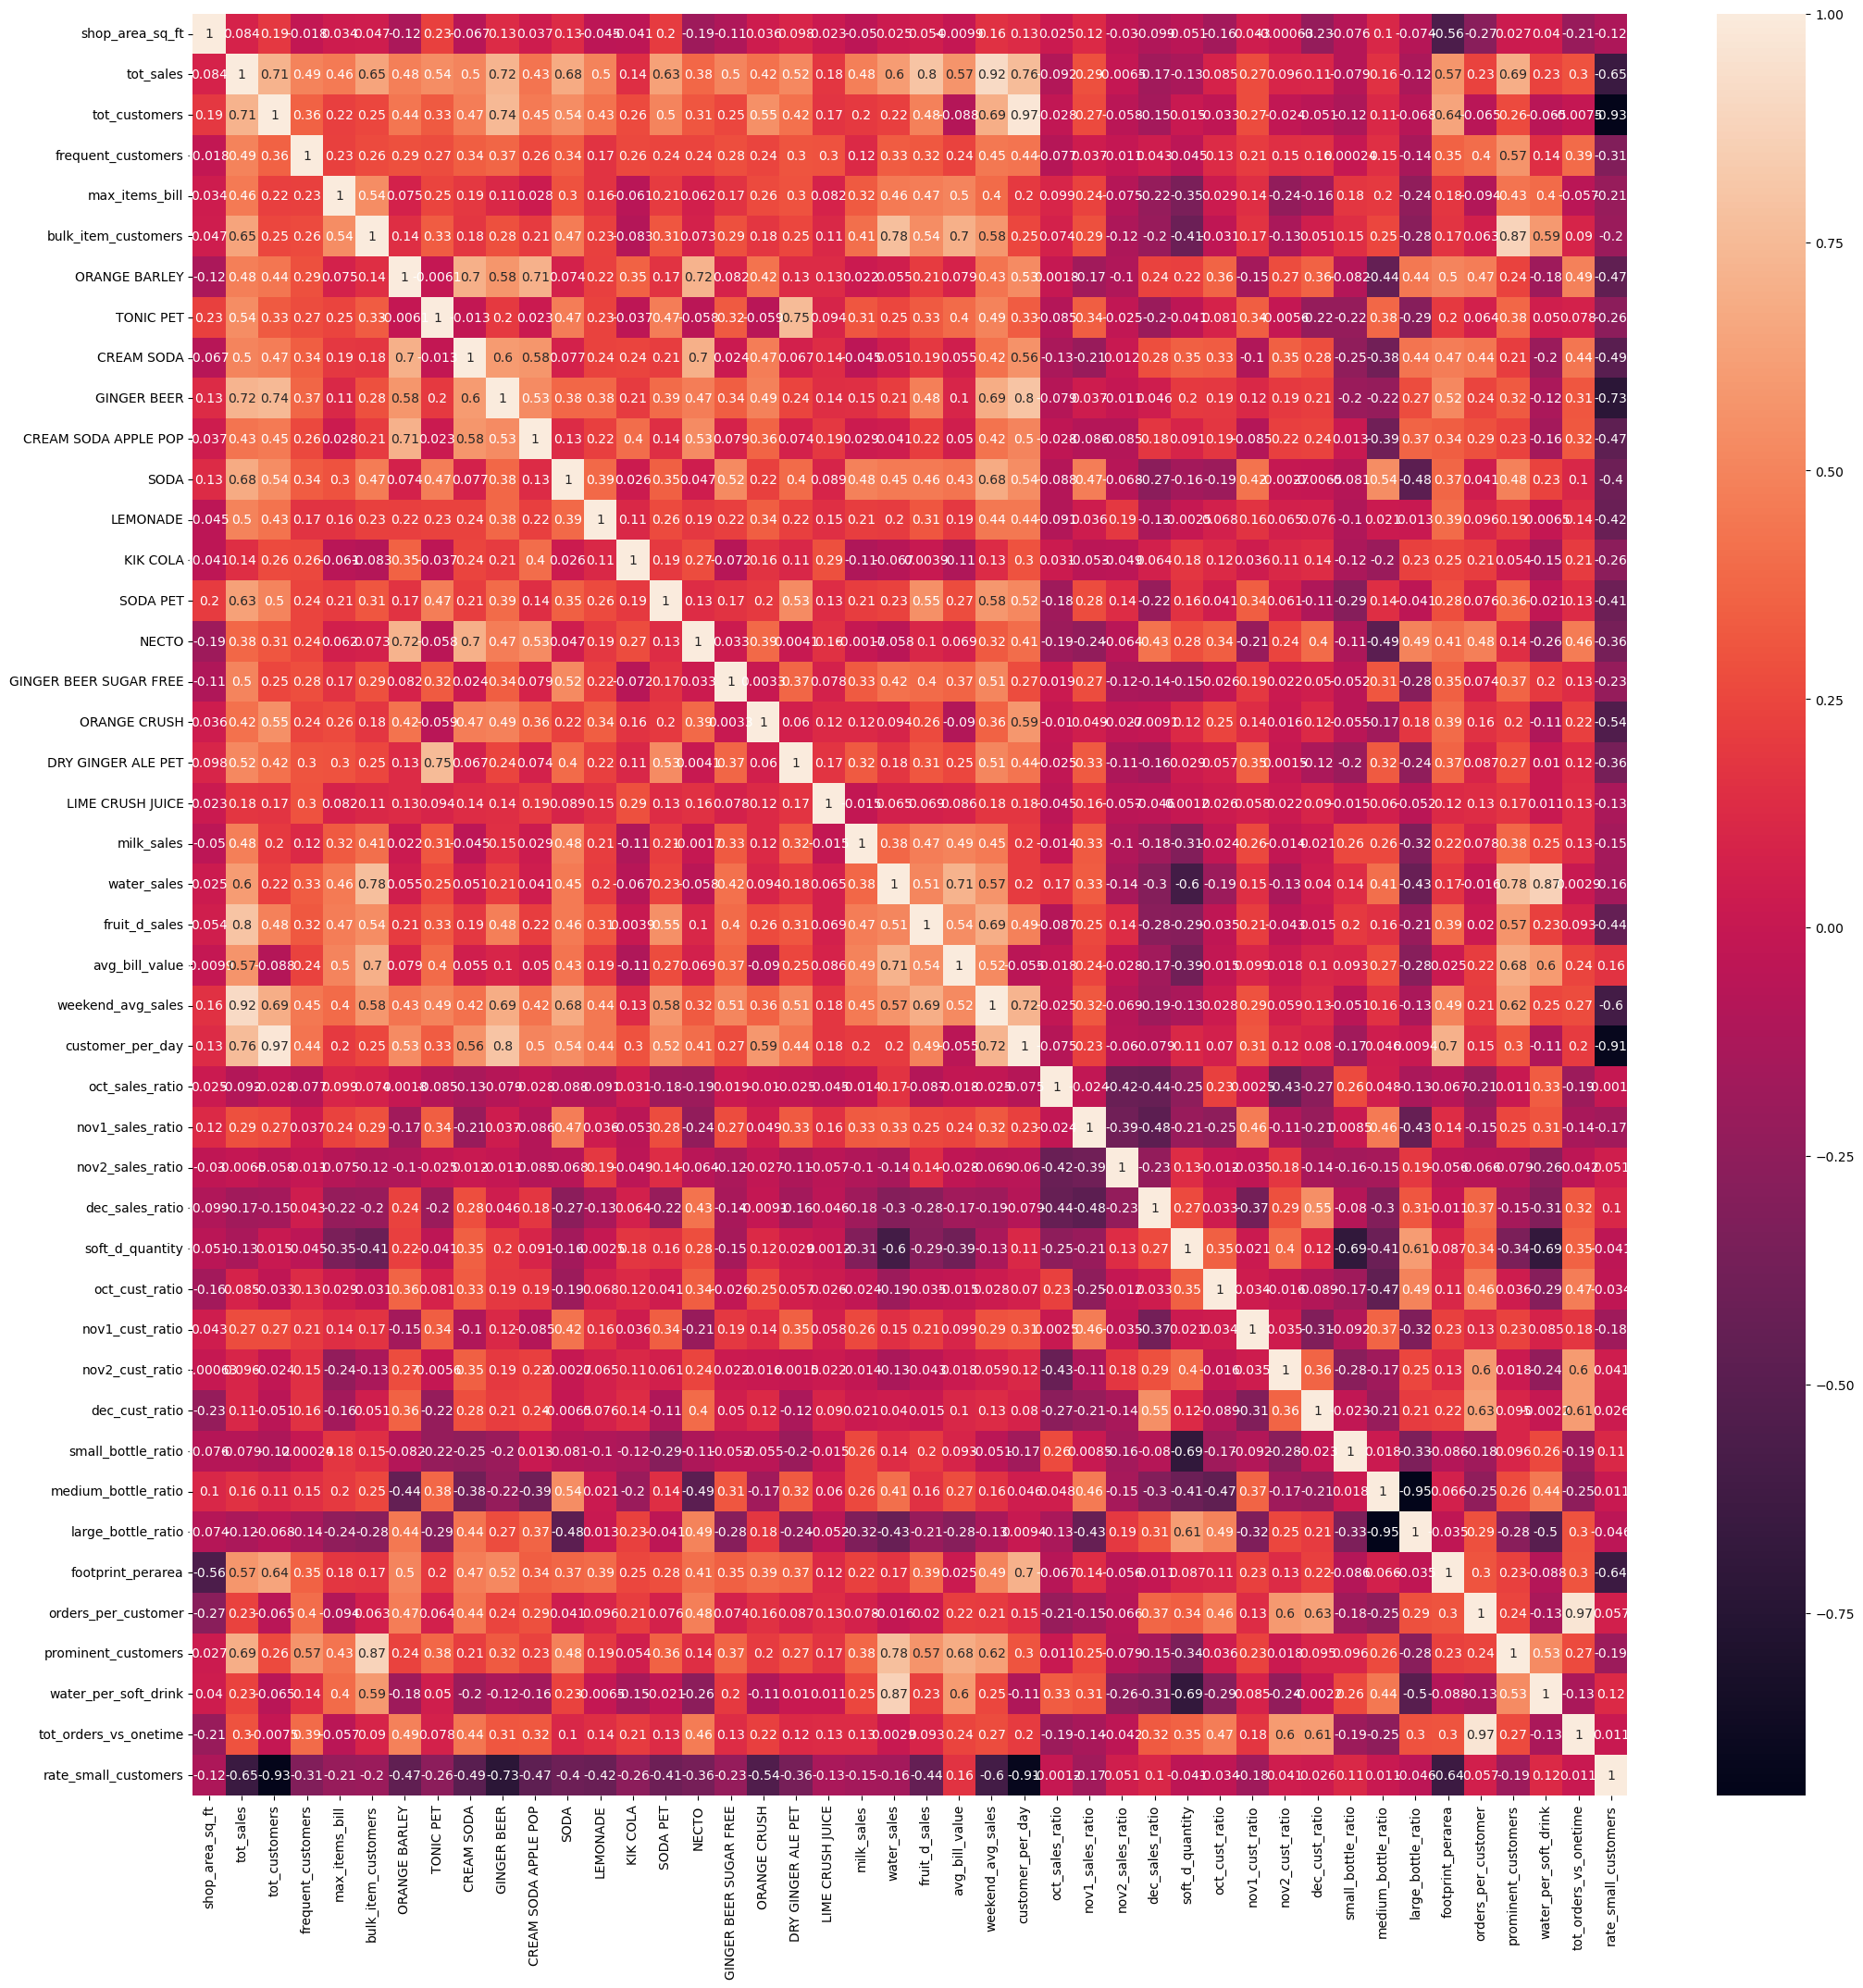

In [60]:
new_frame = store_table
plt.figure(figsize=(25,25))
sns.heatmap(data=new_frame.corr(), annot=True)
plt.show()

## Splitting the data as training, test and validation

In [61]:
store_labelled = store_table.loc[:99]
store_labelled

,shop_id,shop_area_sq_ft,shop_profile,tot_sales,tot_customers,frequent_customers,max_items_bill,bulk_item_customers,ORANGE BARLEY,TONIC PET,...,dec_cust_ratio,small_bottle_ratio,medium_bottle_ratio,large_bottle_ratio,footprint_perarea,orders_per_customer,prominent_customers,water_per_soft_drink,tot_orders_vs_onetime,rate_small_customers
0,SHOP047,528,Moderate,838280,928,3,47,1,36300,34370,...,0.313578,0.138457,0.347362,0.514181,0.039773,1.408405,1.5,0.070497,2.142623,0.001079
1,SHOP009,676,High,1966710,2498,0,38,2,102520,51320,...,0.388711,0.092348,0.371058,0.536594,0.084320,1.417134,0.0,0.042888,2.218045,0.000401
2,SHOP083,676,Low,1691985,1900,2,25,0,146080,37060,...,0.363684,0.088049,0.302830,0.609121,0.065089,1.442105,0.0,0.055127,2.283333,0.000526
3,SHOP117,676,Low,2325980,2037,3,47,5,125180,163370,...,0.396171,0.088071,0.299269,0.612659,0.075444,1.562592,7.5,0.028827,2.661371,0.000492
4,SHOP042,676,Low,1340215,1841,1,30,0,107580,88040,...,0.380228,0.081964,0.350103,0.567933,0.059172,1.370994,0.0,0.044915,2.024058,0.000543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SHOP124,606,High,2967190,2281,3,60,4,70180,279280,...,0.375712,0.112846,0.384404,0.502750,0.087459,1.448049,6.0,0.133991,2.352564,0.000439
96,SHOP012,336,Low,1102670,1262,3,53,2,47520,95780,...,0.417591,0.129832,0.364454,0.505714,0.089286,1.488906,3.0,0.204783,2.200234,0.000794
97,SHOP093,705,High,1726515,1493,3,101,3,38060,56790,...,0.344943,0.137045,0.392836,0.470119,0.042553,1.253851,4.5,0.695042,1.835294,0.000671
98,SHOP004,516,Low,1571700,1744,5,22,0,102740,66600,...,0.397362,0.117013,0.268396,0.614591,0.083333,1.525803,0.0,0.024309,2.522275,0.000573


In [62]:
store_test = store_table.loc[100:]
store_test

,shop_id,shop_area_sq_ft,shop_profile,tot_sales,tot_customers,frequent_customers,max_items_bill,bulk_item_customers,ORANGE BARLEY,TONIC PET,...,dec_cust_ratio,small_bottle_ratio,medium_bottle_ratio,large_bottle_ratio,footprint_perarea,orders_per_customer,prominent_customers,water_per_soft_drink,tot_orders_vs_onetime,rate_small_customers
100,SHOP046,545,NaN,2607865,1736,6,97,5,75460,304310,...,0.368088,0.073621,0.343610,0.582769,0.080734,1.590438,15.0,0.331847,2.622032,0.000578
101,SHOP024,676,NaN,1308795,1641,0,21,0,71280,98700,...,0.346130,0.074896,0.341297,0.583807,0.054734,1.410725,0.0,0.059051,2.177799,0.000609
102,SHOP023,617,NaN,2553330,2227,2,73,4,159720,80330,...,0.355635,0.124448,0.278935,0.596617,0.082658,1.428379,4.0,0.105555,2.216725,0.000450
103,SHOP097,310,NaN,2375735,1667,1,52,1,64680,451960,...,0.381524,0.098042,0.451200,0.450758,0.129032,1.481104,0.5,0.096880,2.380906,0.000600
104,SHOP044,715,NaN,1251090,1550,1,27,0,69960,116850,...,0.333548,0.092148,0.338893,0.568959,0.047552,1.347742,0.0,0.009074,2.008654,0.000645
105,SHOP030,530,NaN,2754185,1636,8,66,8,294800,222880,...,0.382029,0.139315,0.268661,0.592024,0.083019,1.701100,32.0,0.177114,3.034896,0.000614
106,SHOP038,411,NaN,1444025,1781,0,54,1,85140,51350,...,0.373386,0.115747,0.313897,0.570356,0.102190,1.464907,0.0,0.088793,2.274629,0.000562
107,SHOP029,597,NaN,1962105,2052,3,40,3,97900,66970,...,0.437622,0.109656,0.324604,0.565739,0.078727,1.416667,4.5,0.149031,2.234435,0.000488
108,SHOP096,676,NaN,2600915,2497,5,52,1,229900,52350,...,0.419704,0.075478,0.309979,0.614543,0.088757,1.503404,2.5,0.048088,2.471363,0.000401
109,SHOP092,617,NaN,1961240,2247,4,102,2,88440,54550,...,0.341344,0.107900,0.346958,0.545142,0.077796,1.319982,4.0,0.037707,1.974700,0.000445


In [63]:
from sklearn.model_selection import train_test_split
store_train, store_val = train_test_split(store_labelled,test_size = 0.25, random_state = 1)

In [64]:
store_train_x = store_train.drop(columns=['shop_profile'])
store_train_y = store_train.shop_profile

store_val_x = store_val.drop(columns=['shop_profile'])
store_val_y = store_val.shop_profile

store_test_x = store_test.drop(columns=['shop_profile'])

In [65]:
store_train_x.index = store_train_x.shop_id
store_train_x = store_train_x.drop(columns=['shop_id'])

store_val_x.index = store_val_x.shop_id
store_val_x = store_val_x.drop(columns=['shop_id'])

store_test_x.index = store_test_x.shop_id
store_test_x = store_test_x.drop(columns=['shop_id'])

## Feature Scaling

In [66]:
std_scaler = StandardScaler()
data_cols = store_train_x.columns
train_x = std_scaler.fit_transform(store_train_x)
val_x = std_scaler.transform(store_val_x)
test_x = std_scaler.transform(store_test_x)

In [67]:
train_x = pd.DataFrame(train_x, columns=data_cols)
val_x = pd.DataFrame(val_x, columns=data_cols)
test_x = pd.DataFrame(test_x, columns=data_cols)

In [68]:
store_train_y = store_train_y.replace('Low', 0)
store_train_y = store_train_y.replace('Moderate', 1)
store_train_y = store_train_y.replace('High', 2)

store_val_y = store_val_y.replace('Low', 0)
store_val_y = store_val_y.replace('Moderate', 1)
store_val_y = store_val_y.replace('High', 2)

## Feature Selection

In [69]:
feature_sel_model = svm.SVC(kernel='linear')
# feature_sel_model = DecisionTreeClassifier()
# feature_sel_model = xgb.XGBRegressor()

In [70]:
recur_fe = RFE(estimator=feature_sel_model, n_features_to_select = 0.20)
features = recur_fe.fit(train_x, store_train_y )

print("Number of features selected = " + str(features.n_features_))
bool_features_sel = features.support_
rank_features_sel = features.ranking_

Number of features selected = 8


In [71]:
col=0
list_features_sel = []
for i in bool_features_sel:
    if i:
        list_features_sel.append(train_x.columns[col])
    col+=1
list_features_sel

['tot_customers',
 'CREAM SODA',
 'CREAM SODA APPLE POP',
 'KIK COLA',
 'NECTO',
 'milk_sales',
 'avg_bill_value',
 'customer_per_day']

In [72]:
store_table.columns

Index(['shop_id', 'shop_area_sq_ft', 'shop_profile', 'tot_sales',
       'tot_customers', 'frequent_customers', 'max_items_bill',
       'bulk_item_customers', 'ORANGE BARLEY', 'TONIC PET', 'CREAM SODA',
       'GINGER BEER', 'CREAM SODA APPLE POP', 'SODA', 'LEMONADE', 'KIK COLA',
       'SODA PET', 'NECTO', 'GINGER BEER SUGAR FREE', 'ORANGE CRUSH',
       'DRY GINGER ALE PET', 'LIME CRUSH JUICE', 'milk_sales', 'water_sales',
       'fruit_d_sales', 'avg_bill_value', 'weekend_avg_sales',
       'customer_per_day', 'oct_sales_ratio', 'nov1_sales_ratio',
       'nov2_sales_ratio', 'dec_sales_ratio', 'soft_d_quantity',
       'oct_cust_ratio', 'nov1_cust_ratio', 'nov2_cust_ratio',
       'dec_cust_ratio', 'small_bottle_ratio', 'medium_bottle_ratio',
       'large_bottle_ratio', 'footprint_perarea', 'orders_per_customer',
       'prominent_customers', 'water_per_soft_drink', 'tot_orders_vs_onetime',
       'rate_small_customers'],
      dtype='object')

In [73]:
list_features_sel = ['shop_area_sq_ft', 'tot_sales', 'max_items_bill', 'customer_per_day', 'bulk_item_customers', 'avg_bill_value','soft_d_quantity'
                     ,'frequent_customers'
                    ]


# ['shop_area_sq_ft','TONIC PET','CREAM SODA','CREAM SODA APPLE POP','KIK COLA','NECTO','DRY GINGER ALE PET',
#                      'LIME CRUSH JUICE','milk_sales','avg_bill_value','customer_per_day','footprint_perarea','bulk_item_customers',
#                      'water_sales','oct_sales_ratio','nov1_sales_ratio','nov2_sales_ratio','dec_sales_ratio','prominent_customers',
#                      'large_bottle_ratio','tot_orders_vs_onetime','frequent_customers'
#                     ]

In [74]:
train_x_sel = train_x.loc[:,list_features_sel]
val_x_sel = val_x.loc[:,list_features_sel]
test_x_sel = test_x.loc[:,list_features_sel]

<AxesSubplot:>

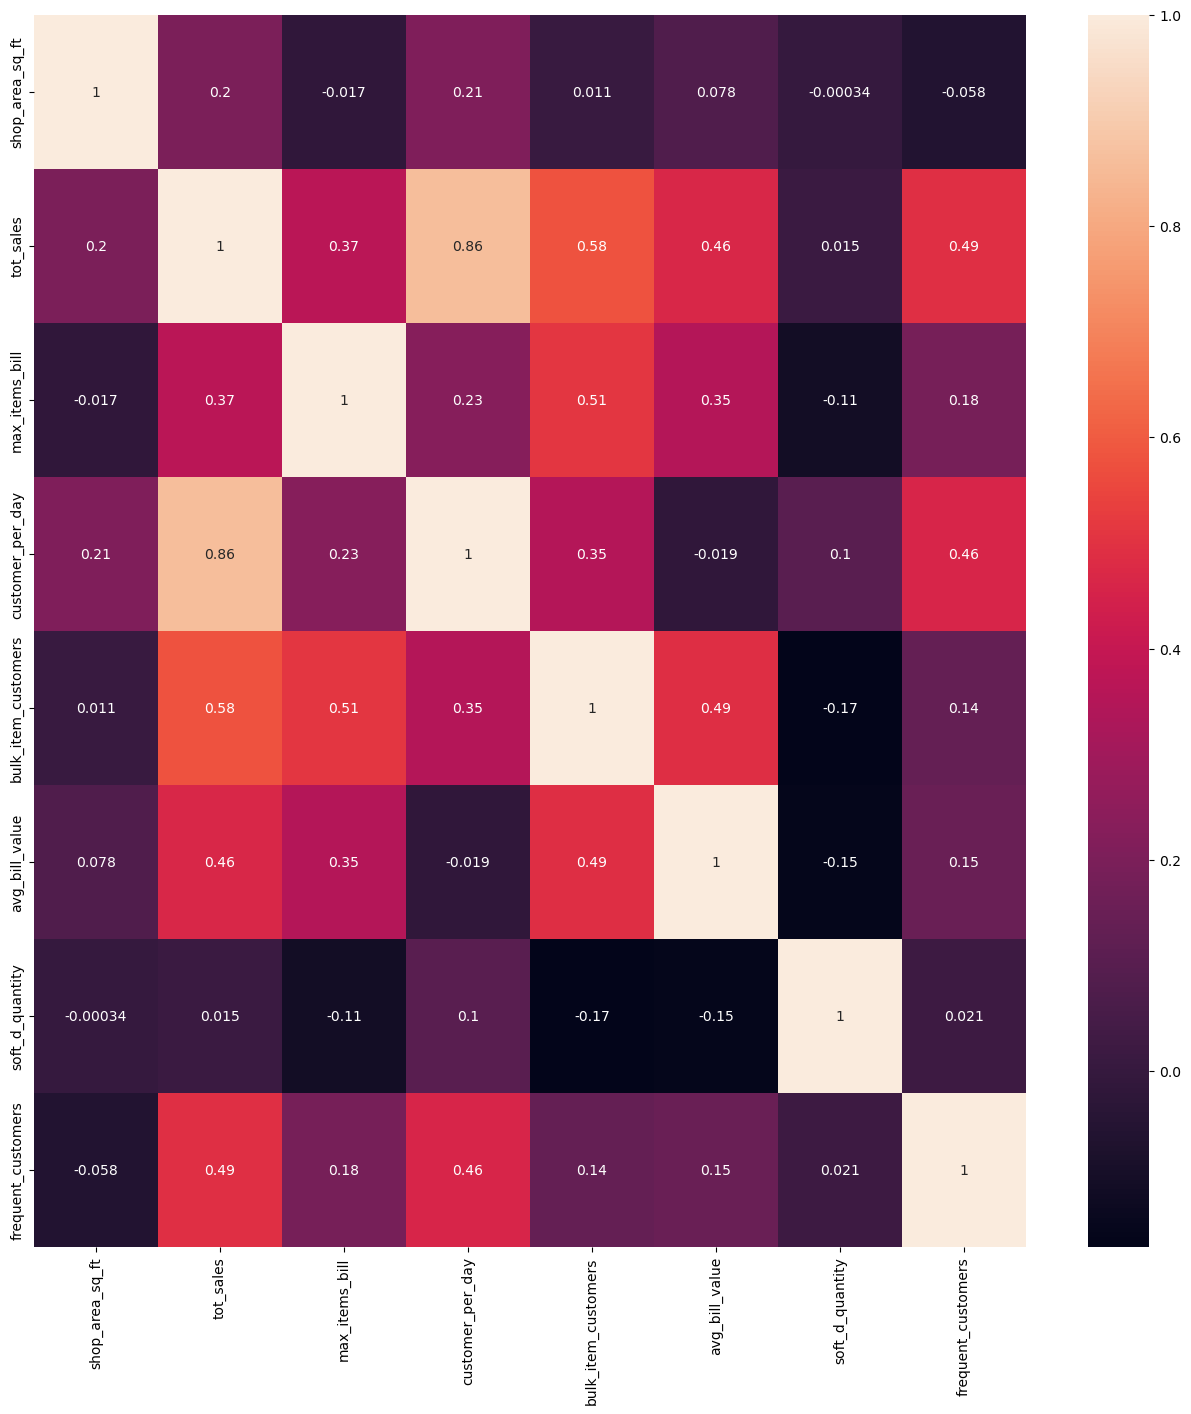

In [75]:
plt.figure(figsize=(16,16))
sns.heatmap(data=train_x_sel.corr(),annot=True)

train_x_sel = train_x_sel.drop(columns=['DRY GINGER ALE PET'])
val_x_sel = val_x_sel.drop(columns=['DRY GINGER ALE PET'])
test_x_sel = test_x_sel.drop(columns=['DRY GINGER ALE PET'])

## Model Training

In [76]:
model = svm.SVC(kernel='rbf')
# model = RandomForestRegressor()
# model = xgb.XGBRegressor()
# model = LinearRegression()
# model = naive_bayes.GaussianNB()
# model = KNeighborsClassifier(n_neighbors=9, weights='distance')

In [77]:
model.fit(train_x_sel, store_train_y)
train_pred_y = model.predict(train_x_sel).round()
print(f1_score(store_train_y,train_pred_y,average='micro'))
val_pred_y = model.predict(val_x_sel).round()
print(f1_score(store_val_y, val_pred_y,average='micro'))

0.8108108108108109
0.72


In [78]:
# b_max=0
# i_arg=1
# for i in range(2,50):
#     knn_model = KNeighborsClassifier(n_neighbors=i, weights='uniform')
#     knn_model.fit(train_x_sel, store_train_y)
#     train_y_pred_knn = knn_model.predict(train_x_sel).astype(int)
#     a = round(f1_score(store_train_y, train_y_pred_knn, average='micro')*100,2)
#     val_y_pred_knn = knn_model.predict(val_x_sel).astype(int)
#     b = round(f1_score(store_val_y, val_y_pred_knn, average='micro')*100,2)
    
#     print(i,a,b)
    
#     if b > b_max:
#         b_max = b
#         i_arg = i
        
# print("Highest Test Accuracy with weighted KNN achieved for neighbours_n = " 
#       + str(i_arg) + "\nwith accuracy of " + str(b_max) + "%")
# model = KNeighborsClassifier(n_neighbors=26, weights='distance')
# model.fit(train_x_sel, store_train_y)

## Predicting

In [79]:
test_pred_y = model.predict(test_x_sel).round()
test_pred_y = pd.DataFrame(test_pred_y)
test_pred_y = test_pred_y.replace(0,'Low')
test_pred_y = test_pred_y.replace(1,'Moderate')
test_pred_y = test_pred_y.replace(2,'High')
test_pred_y.rename(columns={0:'shop_profile'},inplace=True)
test_pred_y

,shop_profile
0,High
1,Low
2,Moderate
3,High
4,Low
5,High
6,Low
7,Low
8,Low
9,Low


In [80]:
test_db = test_db.drop(columns=['shop_profile'])

In [81]:
submission = pd.merge(test_db, test_pred_y, left_index=True, right_index=True)
submission

,shop_id,shop_profile
0,SHOP046,High
1,SHOP024,Low
2,SHOP023,Moderate
3,SHOP097,High
4,SHOP044,Low
5,SHOP030,High
6,SHOP038,Low
7,SHOP029,Low
8,SHOP096,Low
9,SHOP092,Low


In [82]:
submission.shop_profile.value_counts()

Low         12
High         8
Moderate     4
Name: shop_profile, dtype: int64

In [83]:
submission.to_csv('submission6.csv', index=False)